In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("grades.csv")


In [12]:

# Take a quick look at the data
print(df.head())

  FP130 FP130X HE111 HE111S HE111W HE111X HE112 HE112S HE112V HE112W  ...  \
0     V    NaN     V    NaN    NaN    NaN   NaN    NaN     A-    NaN  ...   
1     A    NaN     A    NaN    NaN    NaN     A    NaN    NaN    NaN  ...   
2   NaN      A     V    NaN    NaN    NaN   NaN    NaN    NaN    NaN  ...   
3    C+    NaN    A-    NaN    NaN    NaN     B    NaN    NaN    NaN  ...   
4     B    NaN    A-    NaN    NaN    NaN     A    NaN    NaN    NaN  ...   

  SM221X SM223 SM239 SP211 SP211P SP211R SP212 SP212P SP212R SY110  
0    NaN   NaN   NaN   NaN      A    NaN     A    NaN    NaN     A  
1    NaN   NaN   NaN   NaN    NaN    NaN   NaN    NaN    NaN     A  
2    NaN   NaN   NaN   NaN    NaN    NaN   NaN    NaN    NaN     A  
3    NaN     C   NaN     B    NaN    NaN    B+    NaN    NaN     C  
4    NaN   NaN   NaN     B    NaN    NaN     B    NaN    NaN    B-  

[5 rows x 40 columns]



# Find the number of people that got a specific grade in each course as well as the number of people that took it
# I am counting people that took a class twice, as two different takes


In [3]:
# Reshape into long format
long = df.melt(var_name="course", value_name="grade").dropna(subset=["grade"])

# Split multiple grades in one cell into separate rows
long = long.assign(grade=long["grade"].astype(str).str.split(";"))
long = long.explode("grade").reset_index(drop=True)

# --- Counts summary ---
counts = pd.crosstab(long["course"], long["grade"])

# Rename "V" to "Validated"
if "V" in counts.columns:
    counts = counts.rename(columns={"V": "Validated"})
else:
    counts["Validated"] = 0

# Make sure withdrawals are captured
for w in ["W"]:
    if w not in counts.columns:
        counts[w] = 0

# Total includes EVERY entry (including W, WF, V, etc.)
counts["Total_Took"] = long.groupby("course").size()

# Reorder for readability
grade_order = ["Validated","A","A-","B+","B","B-",
               "C+","C","C-","D+","D","D-","F","W","Total_Took"]
summary = counts.reindex(columns=[c for c in grade_order if c in counts.columns])

summary.head()


grade,Validated,A,A-,B+,B,B-,C+,C,C-,D+,D,F,W,Total_Took
course,,,,,,,,,,,,,,
FP130,864,1545,716,615,952,332,207,327,57,26,60,4,26,5752
FP130X,0,15,12,7,20,3,7,8,0,1,1,1,0,75
HE111,976,1502,802,537,796,171,85,101,28,7,29,1,21,5074
HE111S,0,217,91,68,84,7,2,7,1,0,0,1,3,482
HE111W,0,70,35,28,48,16,5,15,2,2,3,0,3,229


# Try to print LONG DATA FRAME TO CHECK FOR CONSISTENCY IN SPLITTING AND DATA READING






In [4]:
long.to_csv("long_grades.csv", index=False)


# Now Search for the median grade for each course



In [5]:
grade_scale = {
    "A": 4.0,  "A-": 3.7,
    "B+": 3.3, "B": 3.0, "B-": 2.7,
    "C+": 2.3, "C": 2.0, "C-": 1.7,
    "D+": 1.3, "D": 1.0, "D-": 0.7,
    "F": 0.0
}

# Map to numeric, ignore non-graded entries like Validated
long["grade_num"] = long["grade"].map(grade_scale)
valid_grades = long.dropna(subset=["grade_num"])

# Median per course
median_grades = valid_grades.groupby("course")["grade_num"].median()

# Convert back to nearest letter
def num_to_letter(x):
    return min(grade_scale, key=lambda g: abs(grade_scale[g] - x))

median_letters = median_grades.apply(num_to_letter)

# Add to summary
summary["Median_Num"] = median_grades
summary["Median_Grade"] = median_letters

summary


grade,Validated,A,A-,B+,B,B-,C+,C,C-,D+,D,F,W,Total_Took,Median_Num,Median_Grade
course,,,,,,,,,,,,,,,,
FP130,864,1545,716,615,952,332,207,327,57,26,60,4,26,5752,3.30,B+
FP130X,0,15,12,7,20,3,7,8,0,1,1,1,0,75,3.00,B
HE111,976,1502,802,537,796,171,85,101,28,7,29,1,21,5074,3.70,A-
HE111S,0,217,91,68,84,7,2,7,1,0,0,1,3,482,3.70,A-
HE111W,0,70,35,28,48,16,5,15,2,2,3,0,3,229,3.30,B+
HE111X,0,27,13,8,4,1,0,1,0,0,0,0,0,54,3.85,A
HE112,0,1482,736,614,707,175,86,138,25,15,29,6,14,4045,3.70,A-
HE112S,0,237,90,53,69,9,5,7,1,0,2,0,1,474,4.00,A
HE112V,0,398,157,52,66,11,4,3,5,1,1,0,2,700,4.00,A


#H
andling retakes by only looking at final grade, not grade before retake

In [6]:
median_letters.to_frame(name="Median_Grade")

,Median_Grade
course,
FP130,B+
FP130X,B
HE111,A-
HE111S,A-
HE111W,B+
HE111X,A
HE112,A-
HE112S,A
HE112V,A


# Get the class with the most D's and F's


In [7]:
# Combine D's and F's into one total
bad_cols = [c for c in ["D","F"] if c in summary.columns]
D_F_total = summary[bad_cols].sum(axis=1)

# Get top 3 courses with most D/F grades
top3_bad = D_F_total.sort_values(ascending=False).head(3)

# Convert to DataFrame
top3_bad_df = top3_bad.to_frame(name="Number_of_Ds_and_Fs")

top3_bad_df


,Number_of_Ds_and_Fs
course,
SC112,527
SC111,428
SM122,395


# Get the class with the most A's


In [8]:
# Sum A and A- together
A_total = summary[["A"]].sum(axis=1)

# Get top 3 courses with the most A's / A-'s
top3_A = A_total.sort_values(ascending=False).head(3)

# Convert to DataFrame
top3_A_df = top3_A.to_frame(name="Number_of_As_and_A-")

top3_A_df


,Number_of_As_and_A-
course,
NL110,2657
HH104,1837
NE203,1815


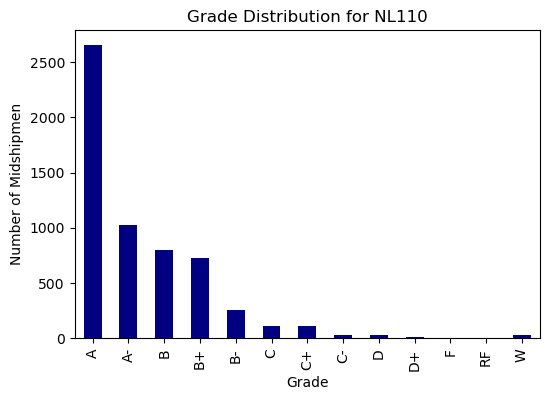

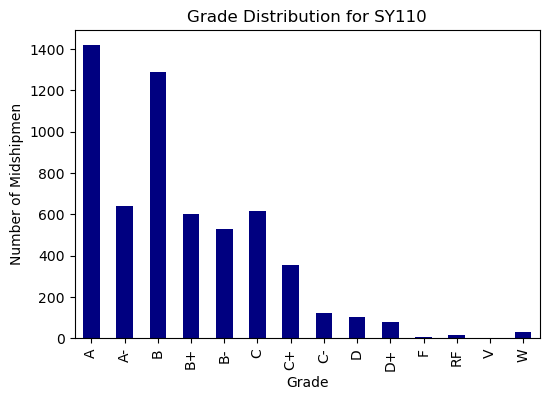

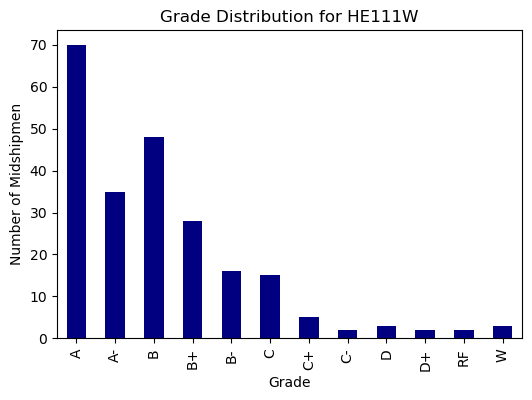

In [9]:
# Choosing to use NL110, SY110, and HE111W as my three classes to compare

import matplotlib.pyplot as plt

courses_to_plot = ["NL110", "SY110", "HE111W"]

for course in courses_to_plot:
    # Filter grades for this course
    course_grades = long[long["course"] == course]["grade"]
    
    # Plot histogram as bar chart
    course_grades.value_counts().sort_index().plot(
        kind="bar",
        figsize=(6,4),
        title=f"Grade Distribution for {course}",
        color="navy"
    )
    plt.xlabel("Grade")
    plt.ylabel("Number of Midshipmen")
    plt.show()


# Calculate the Pearson Correlation between SY110 versus the rest of the coursesCalculate the Pearson’s correlation coefficient between performance in that course and performance in all the other courses

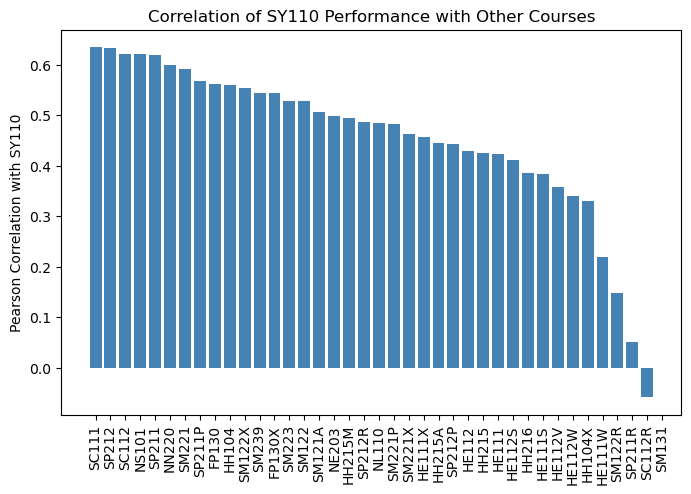

In [10]:
# --- Start from your existing long DataFrame, where grades are split ---
# (if you only had the collapsed version, re-create it this way)
long = df.melt(var_name="course", value_name="grade").dropna(subset=["grade"])
long = long.assign(grade=long["grade"].astype(str).str.split(";"))
long = long.explode("grade").reset_index(drop=True)

# Map grades to numeric
long["grade_num"] = long["grade"].map(grade_scale)

# --- Add a student identifier (row index in original df) ---
df_with_id = df.copy()
df_with_id["MidshipmanID"] = df_with_id.index

long_with_id = df_with_id.melt(
    id_vars="MidshipmanID", var_name="course", value_name="grade"
).dropna(subset=["grade"])

long_with_id = long_with_id.assign(grade=long_with_id["grade"].astype(str).str.split(";"))
long_with_id = long_with_id.explode("grade").reset_index(drop=True)
long_with_id["grade_num"] = long_with_id["grade"].map(grade_scale)

# --- Pivot: rows = Midshipman, columns = course, values = grade_num ---
wide = long_with_id.pivot_table(
    index="MidshipmanID", columns="course", values="grade_num", aggfunc="max"
)

# --- Compute correlations with SY110 ---
correlations = wide.corr()["SY110"].drop("SY110").sort_values(ascending=False)

# Format nicely as DataFrame
correlation_df = correlations.reset_index()
correlation_df.columns = ["Course", "Pearson_r"]

# Show the table
correlation_df

# --- Optional: plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(correlation_df["Course"], correlation_df["Pearson_r"], color="steelblue")
plt.xticks(rotation=90)
plt.ylabel("Pearson Correlation with SY110")
plt.title("Correlation of SY110 Performance with Other Courses")
plt.show()

# Pearson explanation
Classes with a high correlation to SY110 have very similar grade ratios, similar numbers of A's, B's, etc. And classes with a low correlation have very different ratios.
I am suprised to see that SC112R has a negative correlation to it, which makes sense because SC112R has primarily C's and D's compared to SY110 which is mostly A's and B's so relative grades are vastly different. Yes, these results make sense.

One additional interesting question I have is how did 160 people validate SM1313 and only one person took the class and got a D?